In [2]:
from apportionment import *

In [3]:
names = ["100k-large.csv", "250k-large.csv", "500k-large.csv", "1m-large.csv", "2m-large.csv", "4_5m-large.csv"]
sizes = [100000, 250000, 500000, 1000000, 2000000, 4500000]

In [5]:
for name in names:
    raw2visualisable(name)

100k-large.csv done
250k-large.csv done
500k-large.csv done
1m-large.csv done
2m-large.csv done
4_5m-large.csv done


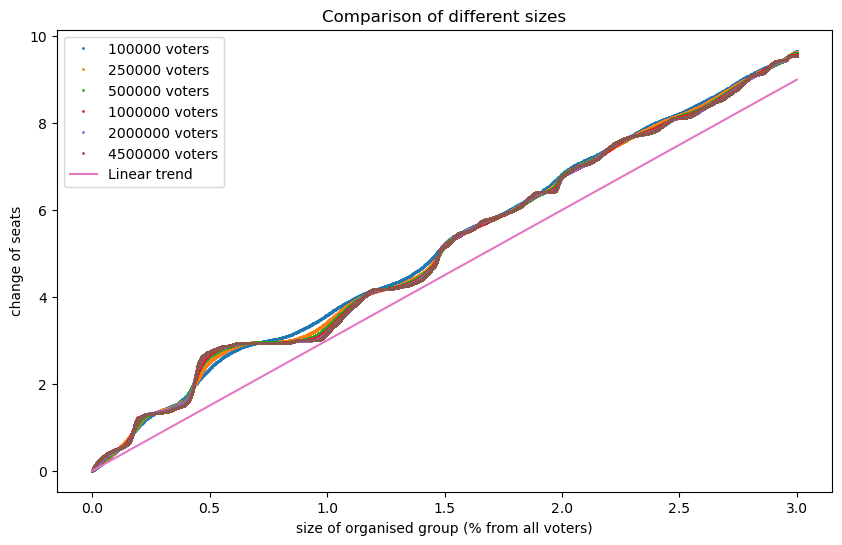

In [12]:
# PLOT

plt.figure(figsize=(10, 6))

for name, size in zip(names, sizes):

    df = pd.read_csv("./vis_data/vis-"+name)

    x_values = (df['samples'] / size) * 100
    y_values = df['diff']


    plt.plot(x_values, y_values, 'o', markersize=1, label=f'{size} voters')


#fix expected trend
x = np.arange(0, 4)
y = (3) * x

plt.plot(x, y, label='Linear trend')
plt.xlabel('size of organised group (% from all voters)')
plt.ylabel('change of seats')
plt.title('Comparison of different sizes')

plt.legend()
plt.show()